In [146]:
from __future__ import annotations
import csv
import json
import re
from dataclasses import dataclass
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def find_repo_root(start: Path | None = None) -> Path:
    """Walk upward until Cargo.toml is found to anchor relative paths."""
    current = (start or Path.cwd()).resolve()
    for candidate in [current, *current.parents]:
        if (candidate / "Cargo.toml").exists():
            return candidate
    raise RuntimeError("Could not locate repository root (missing Cargo.toml)")


REPO_ROOT = find_repo_root()
EVAL_DIR = REPO_ROOT / "python" / "evaluation"
REFERENCE_DIR = EVAL_DIR / "reference-data"

@dataclass
class BandData:
    distances: List[float]
    bands: List[List[float]]
    k_nodes: List[dict]

def load_mpb(path: Path) -> BandData:
    data = json.loads(path.read_text())
    distances = [kp["distance"] for kp in data["k_path"]]
    bands = [list(band) for band in zip(*data["bands"])]
    return BandData(distances, bands, data.get("k_nodes", []))

def load_mpb2d_csv(path: Path) -> BandData:
    with path.open() as handle:
        reader = csv.DictReader(handle)
        distances: List[float] = []
        band_columns = [name for name in reader.fieldnames if name.startswith("band")]
        bands = [[] for _ in band_columns]
        for row in reader:
            distances.append(float(row["k_distance"]))
            for idx, column in enumerate(band_columns):
                value = row[column]
                bands[idx].append(float(value) if value else float("nan"))
    return BandData(distances, bands, [])

In [147]:
DATASET_FILES = {
    ("mpb", "TE"): REFERENCE_DIR / "square_te_eps13_r0p3_res24_k6_b8_mpb.json",
    ("mpb", "TM"): REFERENCE_DIR / "square_tm_eps13_r0p3_res24_k6_b8_mpb.json",
    ("mpb2d", "TE"): REFERENCE_DIR / "square_te_eps13_r0p3_res24_k6_b8_mpb2d.csv",
    ("mpb2d", "TM"): REFERENCE_DIR / "square_tm_eps13_r0p3_res24_k6_b8_mpb2d.csv",
}

DATASET_LOADERS = {
    "mpb": load_mpb,
    "mpb2d": load_mpb2d_csv,
}

POL_COLORS = {"TE": "tab:orange", "TM": "tab:blue"}
PANEL_TITLES = {"mpb": "MPB (reference)", "mpb2d": "mpb2d-cli"}

# NOTE: mpb2d and MPB use the SAME TE/TM convention:
#   TE = H_z scalar, curl-curl operator -∇·(ε⁻¹∇)
#   TM = E_z scalar, Laplacian with ε mass matrix

def load_dataset(dataset: str, pol: str) -> BandData:
    key = dataset.lower()
    pol_key = pol.upper()
    # No swap needed - mpb2d now uses the same convention as MPB
    path = DATASET_FILES[(key, pol_key)]
    loader = DATASET_LOADERS[key]
    return loader(path)

def extract_node_metadata():
    try:
        ref = load_dataset("mpb", "TE")
    except FileNotFoundError:
        return [], []
    if not ref.k_nodes:
        return [], []
    positions = [node.get("distance", idx) for idx, node in enumerate(ref.k_nodes)]
    labels = [node.get("label", f"K{idx}") for idx, node in enumerate(ref.k_nodes)]
    return positions, labels

node_positions, node_labels = extract_node_metadata()

def align_distances(distances):
    if not distances:
        return []
    values = np.asarray(distances, dtype=float)
    values = values - values[0]
    span = values[-1] if values[-1] != 0 else 1.0
    target_span = node_positions[-1] if node_positions else span
    scale = target_span / span if span else 1.0
    return (values * scale).tolist()

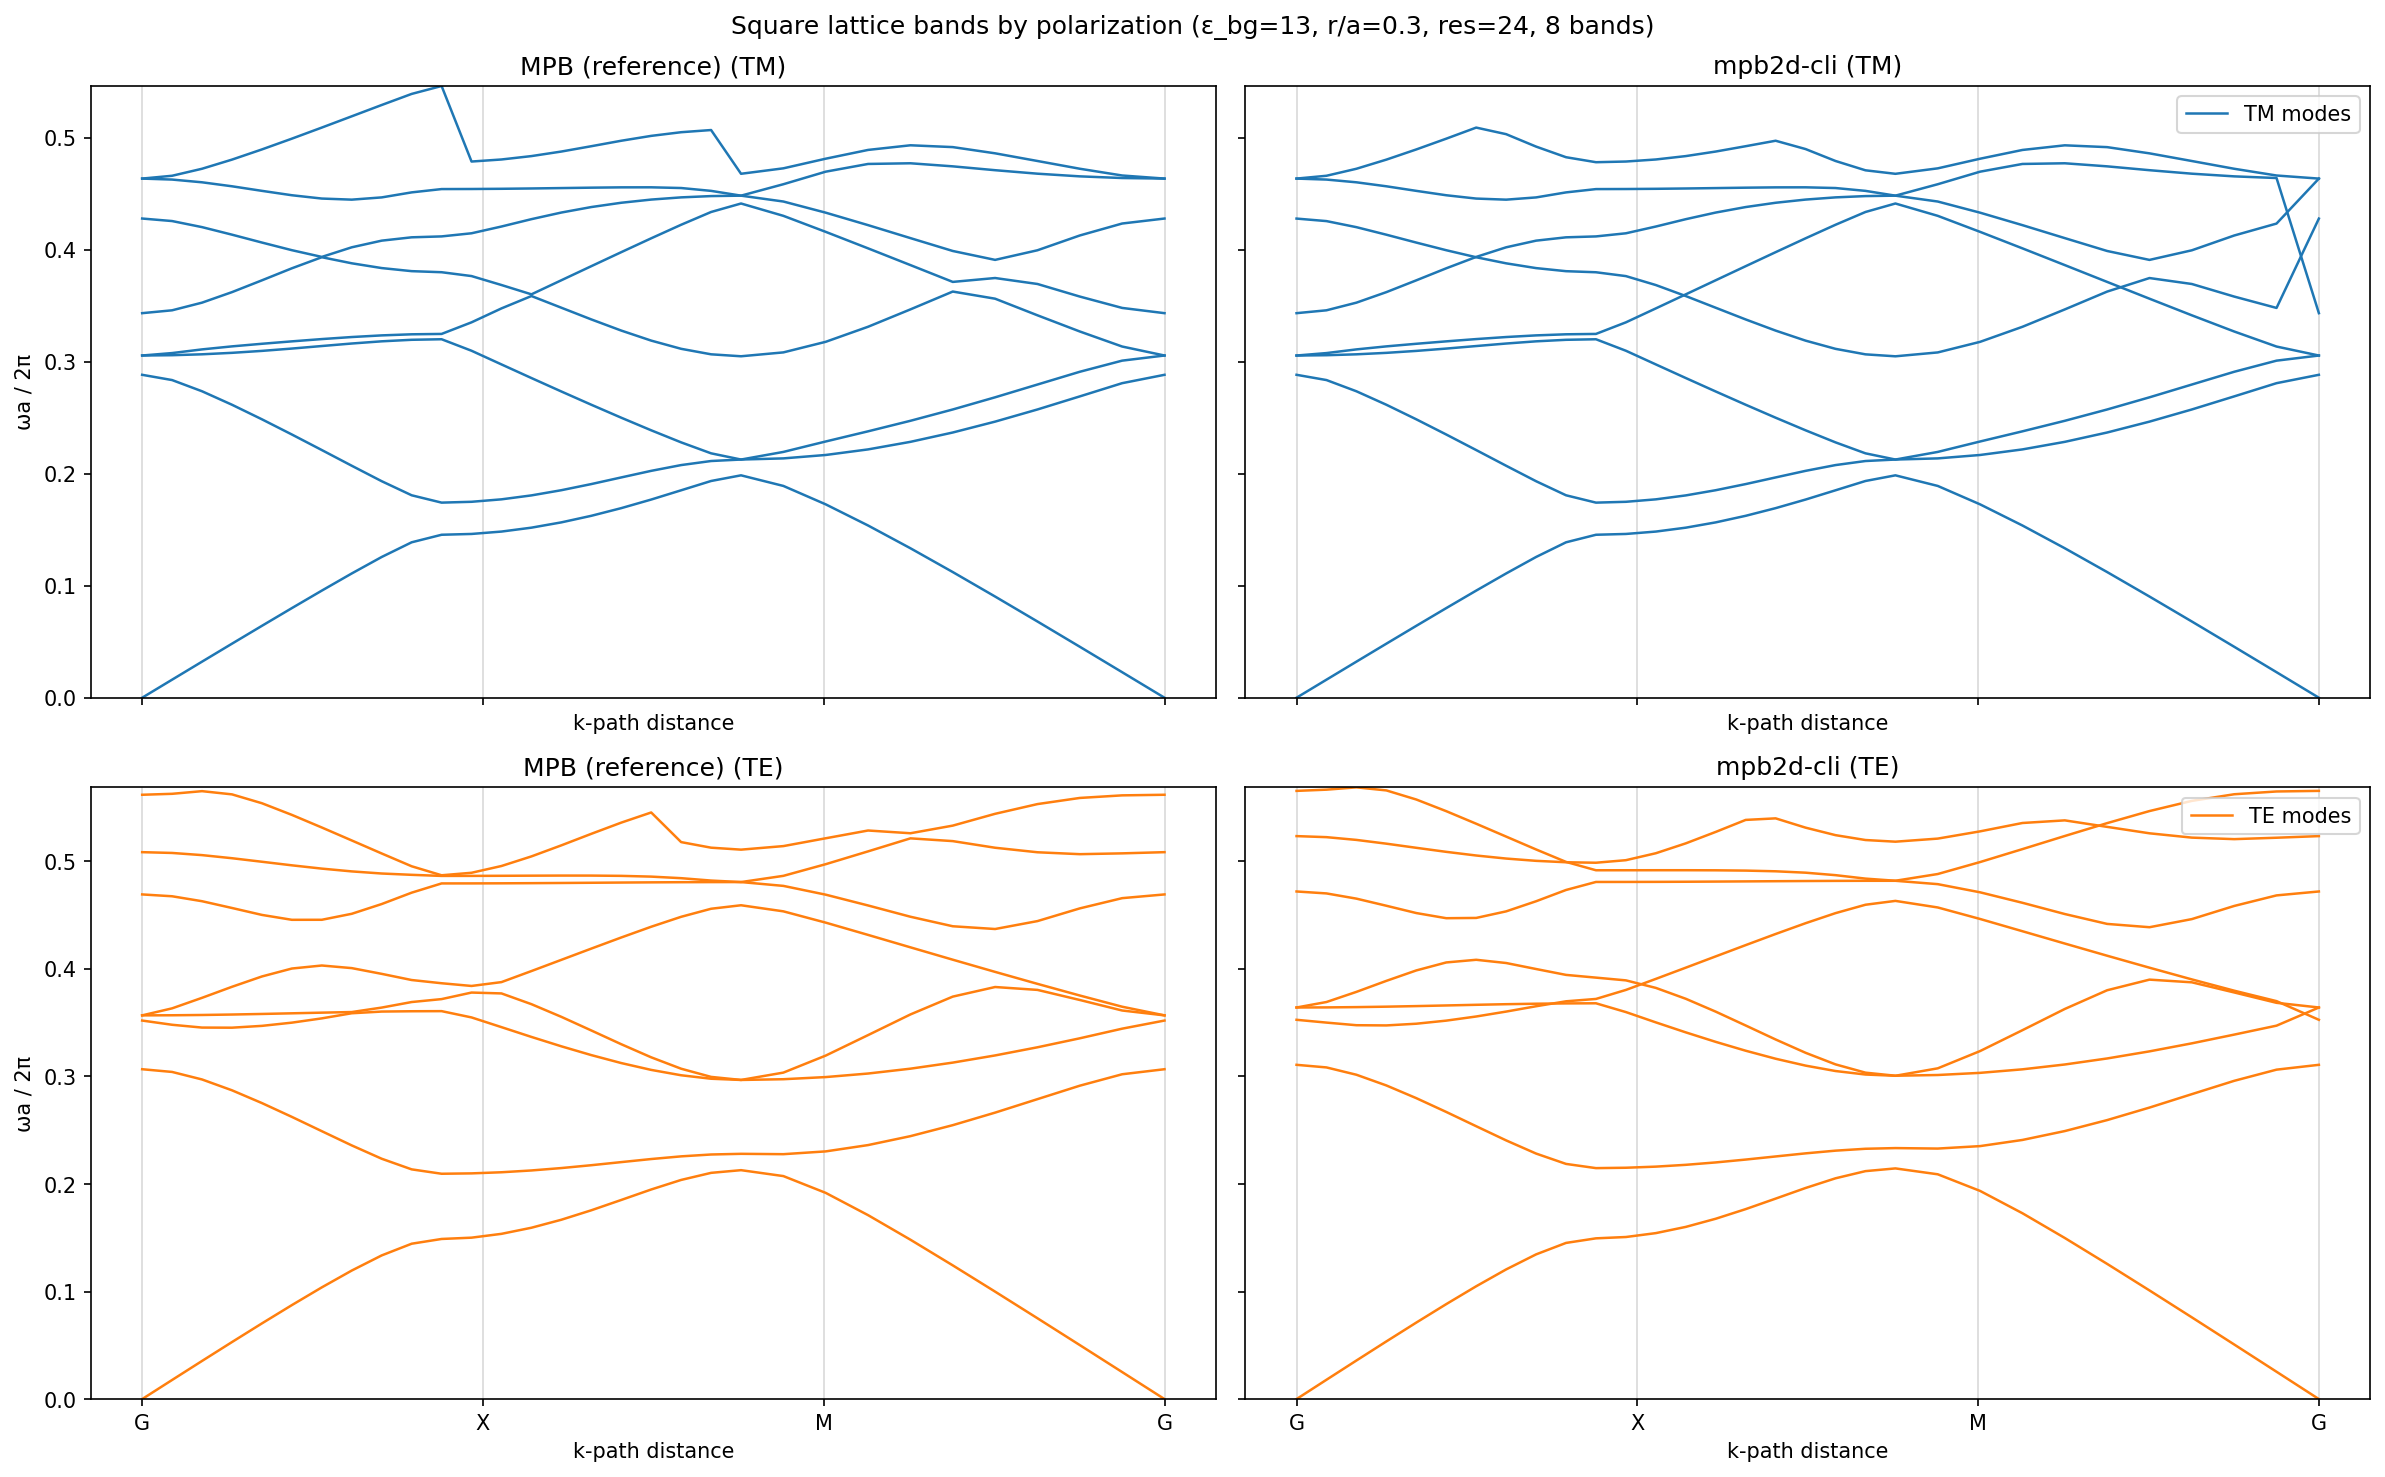

In [148]:
pol_order = ["TM", "TE"]
dataset_order = ["mpb", "mpb2d"]

fig, axes = plt.subplots(
    2,
    2,
    figsize=(16, 10),
    sharex=True,
    sharey="row",
    dpi=150,
 )

row_limits = {pol: [float("inf"), float("-inf")] for pol in pol_order}

for row_idx, pol in enumerate(pol_order):
    for col_idx, dataset in enumerate(dataset_order):
        ax = axes[row_idx, col_idx]
        data = load_dataset(dataset, pol)
        distances = align_distances(data.distances)

        for band_idx, band in enumerate(data.bands):
            label = f"{pol} modes" if band_idx == 0 else None
            
            ax.plot(
                distances,
                band,
                color=POL_COLORS[pol],
                linewidth=1.2,
                label=label,
            )

            finite_vals = [value for value in band if not (value != value)]
            if finite_vals:
                row_limits[pol][0] = min(row_limits[pol][0], min(finite_vals))
                row_limits[pol][1] = max(row_limits[pol][1], max(finite_vals))

        if node_positions:
            ax.set_xticks(node_positions)
            ax.set_xticklabels(node_labels)
            for pos in node_positions:
                ax.axvline(pos, color="0.85", linewidth=0.8, zorder=0)

        ax.set_title(f"{PANEL_TITLES[dataset]} ({pol})")
        ax.set_xlabel("k-path distance")
        if col_idx == 0:
            ax.set_ylabel("ωa / 2π")

    axes[row_idx, 1].legend(loc="upper right")

for row_idx, pol in enumerate(pol_order):
    y_min, y_max = row_limits[pol]
    if y_min < y_max:
        for ax in axes[row_idx]:
            ax.set_ylim(y_min, y_max)

fig.suptitle("Square lattice bands by polarization (ε_bg=13, r/a=0.3, res=24, 8 bands)")
fig.tight_layout()
plt.show()


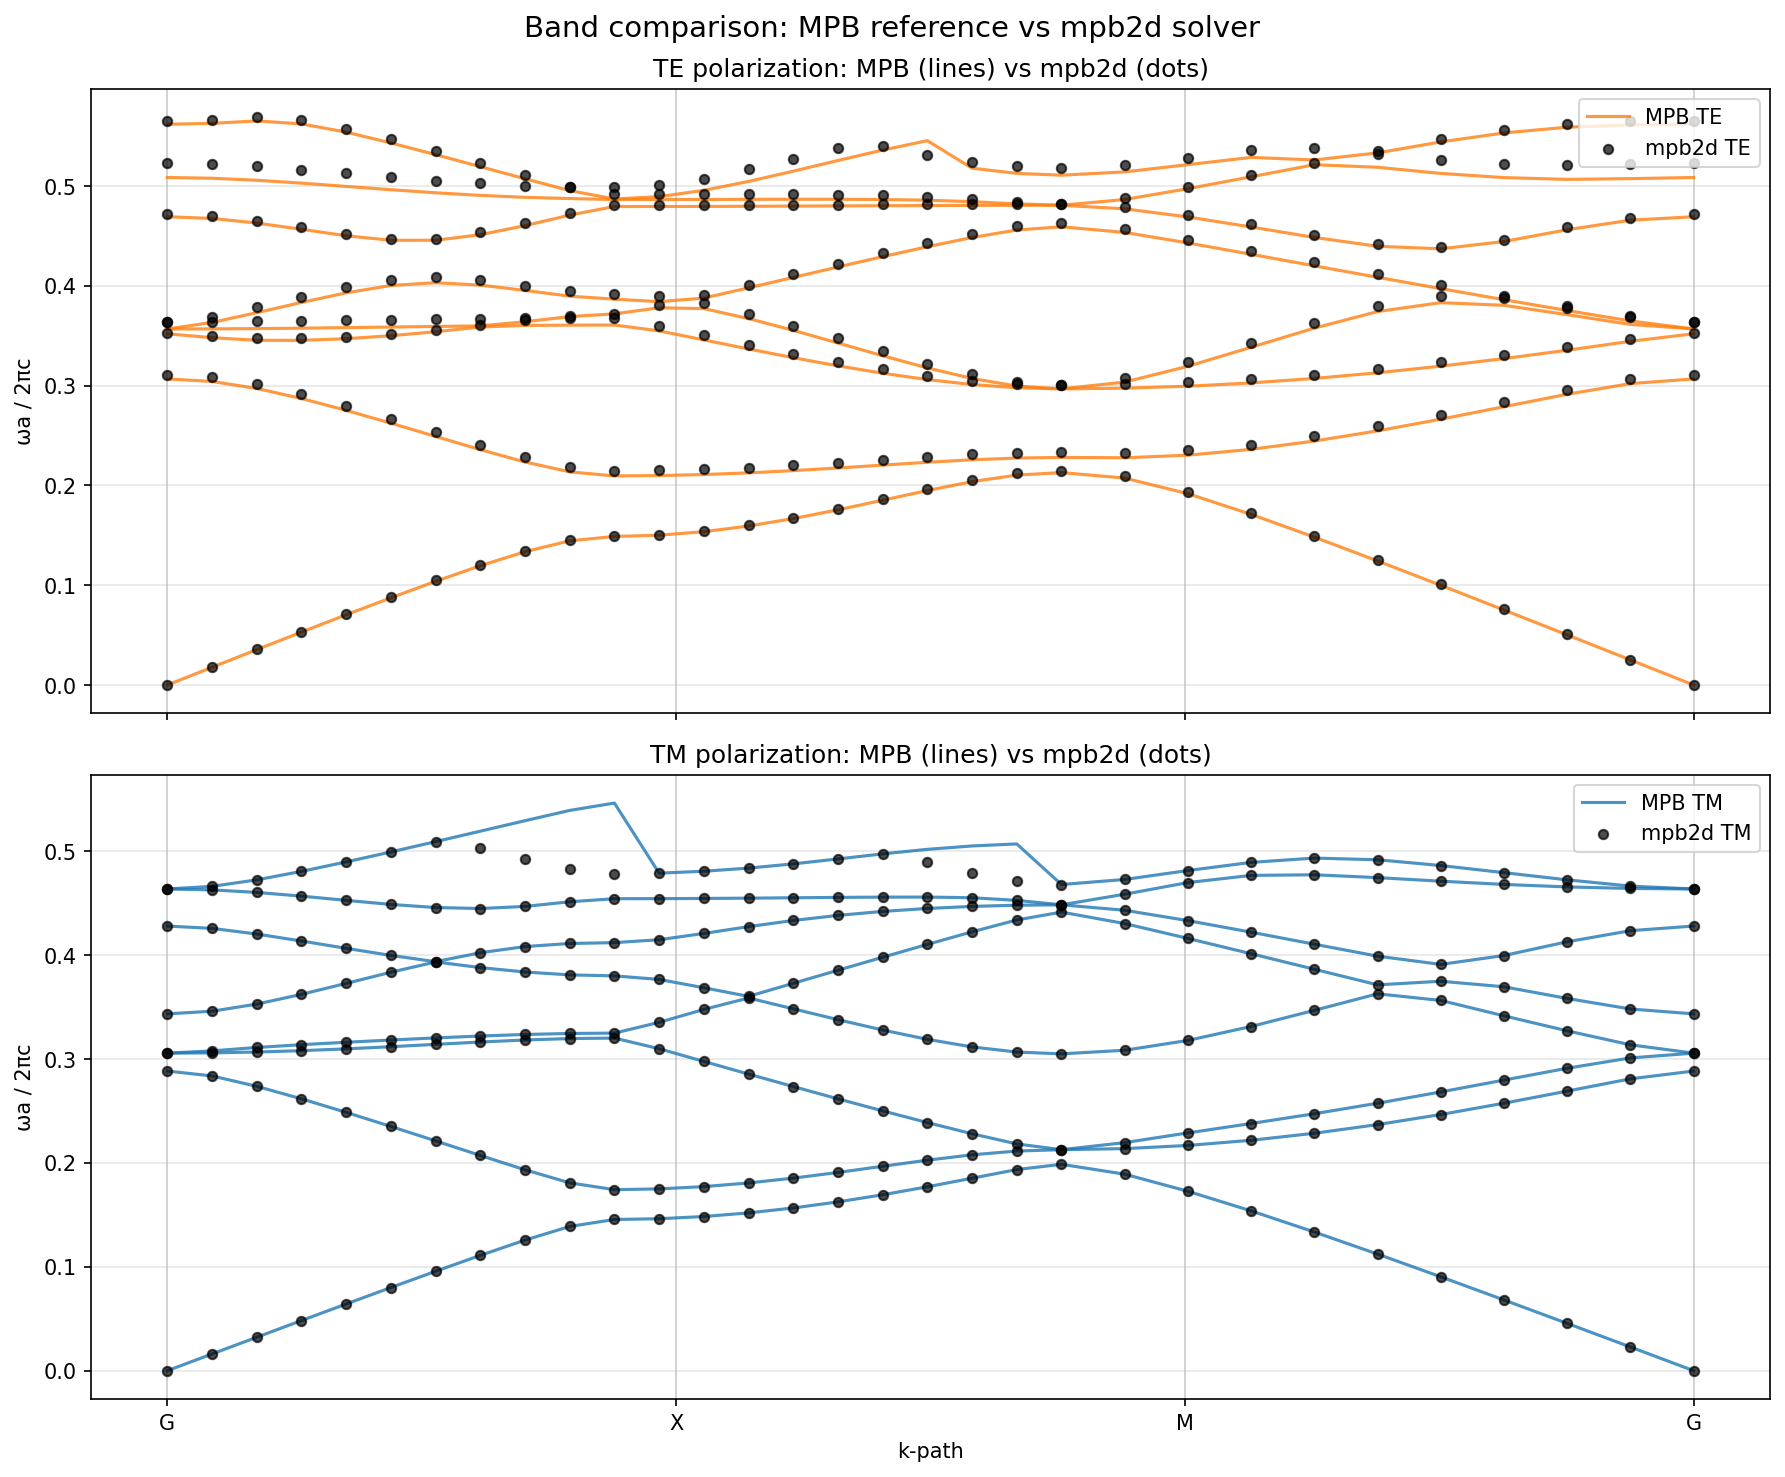

In [149]:
# Merged band comparison: MPB (lines) vs mpb2d (dots) for both polarizations
# Same polarization comparison (TE vs TE, TM vs TM)

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, dpi=150)

for row_idx, pol in enumerate(["TE", "TM"]):
    ax = axes[row_idx]
    
    # Plot MPB reference as lines
    mpb_data = load_dataset("mpb", pol)
    mpb_distances = align_distances(mpb_data.distances)
    for band_idx, band in enumerate(mpb_data.bands):
        label = f"MPB {pol}" if band_idx == 0 else None
        ax.plot(
            mpb_distances,
            band,
            color=POL_COLORS[pol],
            linewidth=1.5,
            label=label,
            alpha=0.8,
        )
    
    # Plot mpb2d with same polarization
    mpb2d_data = load_dataset("mpb2d", pol)
    mpb2d_distances = align_distances(mpb2d_data.distances)
    for band_idx, band in enumerate(mpb2d_data.bands):
        label = f"mpb2d {pol}" if band_idx == 0 else None
        ax.scatter(
            mpb2d_distances,
            band,
            color="black",
            s=20,
            marker="o",
            label=label,
            zorder=3,
            alpha=0.7,
        )
    
    # Add high-symmetry point markers
    if node_positions:
        ax.set_xticks(node_positions)
        ax.set_xticklabels(node_labels)
        for pos in node_positions:
            ax.axvline(pos, color="0.85", linewidth=0.8, zorder=0)
    
    ax.set_ylabel("ωa / 2πc")
    ax.set_title(f"{pol} polarization: MPB (lines) vs mpb2d (dots)")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("k-path")
fig.suptitle("Band comparison: MPB reference vs mpb2d solver", fontsize=14)
fig.tight_layout()
plt.show()

In [150]:
# ============================================================================
# Eigenvalue Validation: Trace comparison & nearest-neighbor matching
# ============================================================================
# Test 1: Per-k-point trace comparison (sum of all eigenvalues)
#         This is exact for non-degenerate bands, slightly off for degenerate ones
# Test 2: Nearest-neighbor matching - find closest points and report deviations
#         This accounts for band tracking issues

from scipy.optimize import linear_sum_assignment

def compute_trace_per_k(data: BandData) -> np.ndarray:
    """Compute sum of all band frequencies at each k-point."""
    bands = np.array(data.bands)  # shape: (num_bands, num_k)
    return np.nansum(bands, axis=0)

def nearest_neighbor_match(mpb_bands: np.ndarray, mpb2d_bands: np.ndarray) -> dict:
    """
    For each k-point, find optimal assignment of mpb2d bands to mpb bands
    using Hungarian algorithm. Returns per-band deviations after optimal matching.
    """
    num_bands, num_k = mpb_bands.shape
    
    matched_deviations = []  # deviation per (k, band) after optimal matching
    unmatched_counts = []    # count of mpb2d points with no close mpb match
    
    for k_idx in range(num_k):
        mpb_vals = mpb_bands[:, k_idx]
        mpb2d_vals = mpb2d_bands[:, k_idx]
        
        # Skip if any NaN
        if np.any(np.isnan(mpb_vals)) or np.any(np.isnan(mpb2d_vals)):
            continue
        
        # Build cost matrix: |mpb[i] - mpb2d[j]|
        cost = np.abs(mpb_vals[:, None] - mpb2d_vals[None, :])
        
        # Hungarian algorithm for optimal assignment
        row_ind, col_ind = linear_sum_assignment(cost)
        
        # Collect deviations after optimal matching
        for i, j in zip(row_ind, col_ind):
            matched_deviations.append({
                'k_idx': k_idx,
                'mpb_band': i,
                'mpb2d_band': j,
                'mpb_val': mpb_vals[i],
                'mpb2d_val': mpb2d_vals[j],
                'deviation': abs(mpb_vals[i] - mpb2d_vals[j]),
            })
    
    return matched_deviations

# Compute for both polarizations
validation_results = {}

for pol in ["TE", "TM"]:
    mpb_data = load_dataset("mpb", pol)
    mpb2d_data = load_dataset("mpb2d", pol)
    
    # Align distances for consistency
    mpb_distances = align_distances(mpb_data.distances)
    mpb2d_distances = align_distances(mpb2d_data.distances)
    
    mpb_bands = np.array(mpb_data.bands)
    mpb2d_bands = np.array(mpb2d_data.bands)
    
    # Test 1: Trace comparison
    mpb_trace = compute_trace_per_k(mpb_data)
    mpb2d_trace = compute_trace_per_k(mpb2d_data)
    trace_diff = mpb2d_trace - mpb_trace
    
    # Test 2: Nearest-neighbor matching
    matched = nearest_neighbor_match(mpb_bands, mpb2d_bands)
    
    validation_results[pol] = {
        'distances': mpb_distances,
        'mpb_trace': mpb_trace,
        'mpb2d_trace': mpb2d_trace,
        'trace_diff': trace_diff,
        'matched_deviations': matched,
    }

# Print summary statistics
print("=" * 70)
print("EIGENVALUE VALIDATION SUMMARY")
print("=" * 70)

for pol in ["TE", "TM"]:
    res = validation_results[pol]
    deviations = [m['deviation'] for m in res['matched_deviations']]
    
    print(f"\n{pol} polarization:")
    print(f"  Trace difference (mpb2d - mpb):")
    print(f"    Mean: {np.mean(res['trace_diff']):+.6f}")
    print(f"    Max:  {np.max(np.abs(res['trace_diff'])):+.6f}")
    print(f"    Std:  {np.std(res['trace_diff']):.6f}")
    
    print(f"  After optimal band matching (Hungarian algorithm):")
    print(f"    Mean deviation: {np.mean(deviations):.6f}")
    print(f"    Max deviation:  {np.max(deviations):.6f}")
    print(f"    Points with dev > 0.01: {sum(1 for d in deviations if d > 0.01)}")
    print(f"    Points with dev > 0.001: {sum(1 for d in deviations if d > 0.001)}")
    print(f"    Points with dev > 1e-4: {sum(1 for d in deviations if d > 1e-4)}")

EIGENVALUE VALIDATION SUMMARY

TE polarization:
  Trace difference (mpb2d - mpb):
    Mean: +0.035079
    Max:  +0.040822
    Std:  0.006321
  After optimal band matching (Hungarian algorithm):
    Mean deviation: 0.004499
    Max deviation:  0.014931
    Points with dev > 0.01: 24
    Points with dev > 0.001: 227
    Points with dev > 1e-4: 246

TM polarization:
  Trace difference (mpb2d - mpb):
    Mean: -0.008181
    Max:  +0.068156
    Std:  0.017527
  After optimal band matching (Hungarian algorithm):
    Mean deviation: 0.001023
    Max deviation:  0.068074
    Points with dev > 0.01: 7
    Points with dev > 0.001: 7
    Points with dev > 1e-4: 7


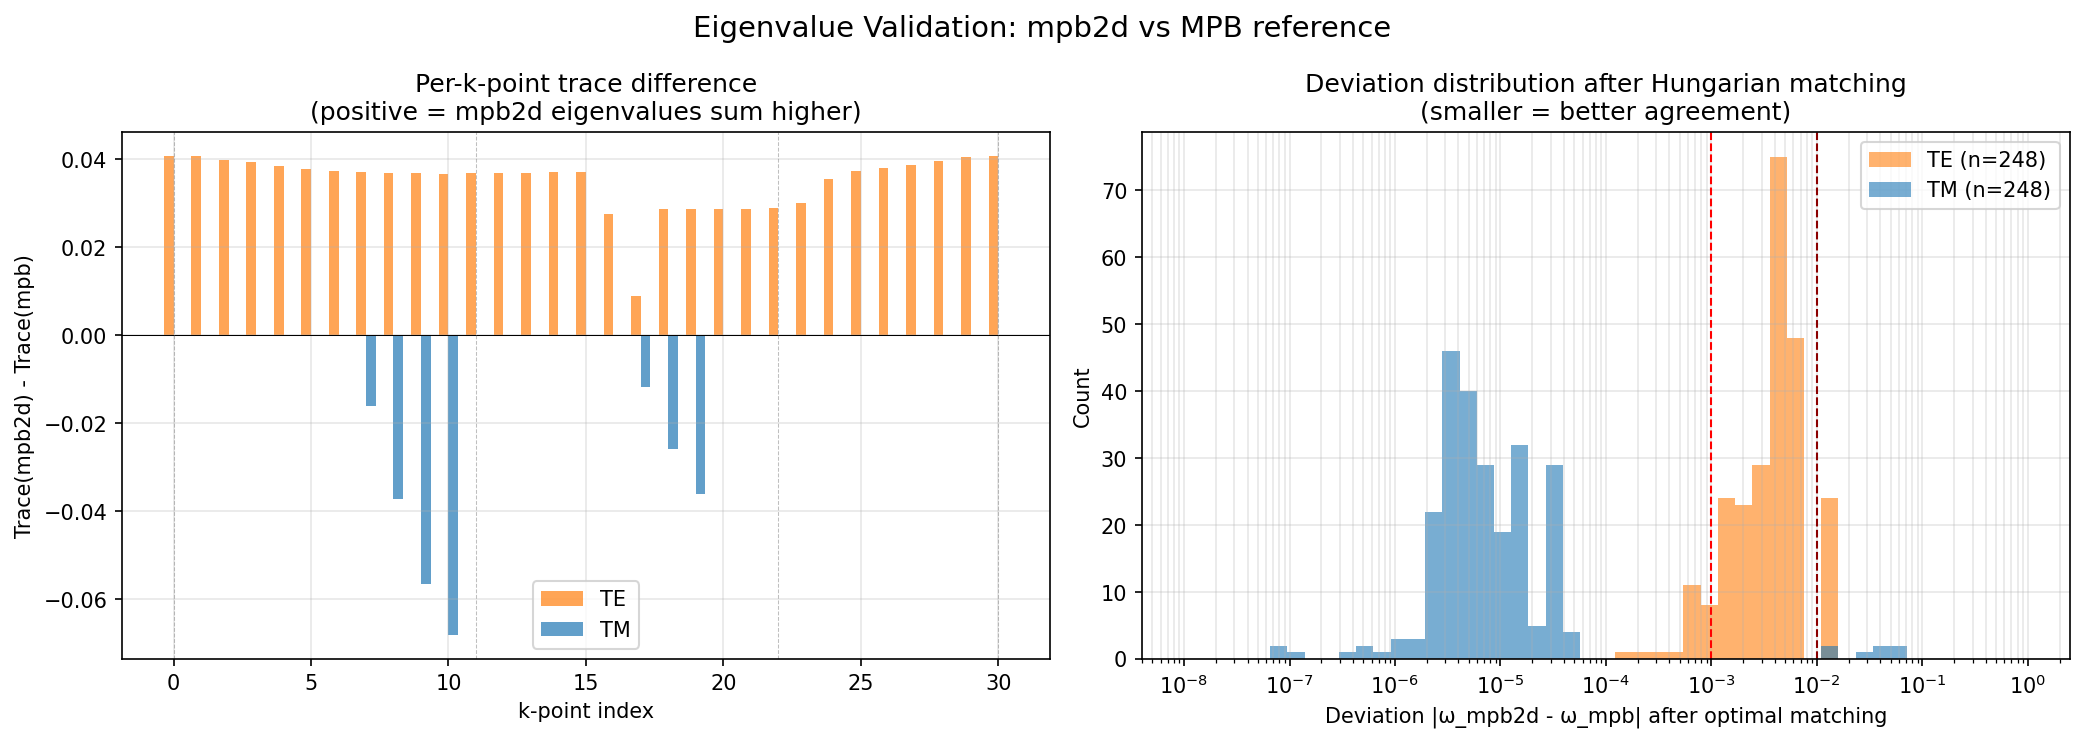


Largest deviations (top 10):
  TM k#10 band8: mpb=0.5464, mpb2d=0.4783, Δ=0.0681
  TM k#09 band8: mpb=0.5393, mpb2d=0.4828, Δ=0.0565
  TM k#08 band8: mpb=0.5294, mpb2d=0.4923, Δ=0.0372
  TM k#19 band8: mpb=0.5071, mpb2d=0.4711, Δ=0.0360
  TM k#18 band8: mpb=0.5051, mpb2d=0.4794, Δ=0.0257
  TM k#07 band8: mpb=0.5193, mpb2d=0.5034, Δ=0.0160
  TE k#30 band7: mpb=0.5086, mpb2d=0.5235, Δ=0.0149
  TE k#00 band7: mpb=0.5086, mpb2d=0.5235, Δ=0.0149
  TE k#01 band7: mpb=0.5079, mpb2d=0.5226, Δ=0.0147
  TE k#29 band7: mpb=0.5075, mpb2d=0.5220, Δ=0.0145


In [151]:
# ============================================================================
# Visualization: Trace difference & deviation histogram
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# --- Left plot: Trace difference per k-point (bar plot) ---
ax_trace = axes[0]
width = 0.35
x_positions = np.arange(len(validation_results["TE"]["distances"]))

for i, pol in enumerate(["TE", "TM"]):
    res = validation_results[pol]
    offset = (i - 0.5) * width
    bars = ax_trace.bar(
        x_positions + offset,
        res['trace_diff'],
        width,
        label=f"{pol}",
        color=POL_COLORS[pol],
        alpha=0.7,
    )

ax_trace.axhline(0, color='black', linewidth=0.5, linestyle='-')
ax_trace.set_xlabel("k-point index")
ax_trace.set_ylabel("Trace(mpb2d) - Trace(mpb)")
ax_trace.set_title("Per-k-point trace difference\n(positive = mpb2d eigenvalues sum higher)")
ax_trace.legend()
ax_trace.grid(True, alpha=0.3)

# Add node markers if available
if node_positions:
    distances = validation_results["TE"]["distances"]
    for pos, label in zip(node_positions, node_labels):
        # Find closest k-index
        k_idx = np.argmin(np.abs(np.array(distances) - pos))
        ax_trace.axvline(k_idx, color='gray', linewidth=0.5, linestyle='--', alpha=0.5)

# --- Right plot: Deviation histogram after optimal matching ---
ax_hist = axes[1]

for pol in ["TE", "TM"]:
    deviations = [m['deviation'] for m in validation_results[pol]['matched_deviations']]
    
    # Use log-spaced bins
    bins = np.logspace(-8, 0, 50)
    ax_hist.hist(
        deviations,
        bins=bins,
        alpha=0.6,
        label=f"{pol} (n={len(deviations)})",
        color=POL_COLORS[pol],
    )

ax_hist.set_xscale('log')
ax_hist.set_xlabel("Deviation |ω_mpb2d - ω_mpb| after optimal matching")
ax_hist.set_ylabel("Count")
ax_hist.set_title("Deviation distribution after Hungarian matching\n(smaller = better agreement)")
ax_hist.legend()
ax_hist.grid(True, alpha=0.3, which='both')
ax_hist.axvline(1e-3, color='red', linestyle='--', linewidth=1, label='0.001 threshold')
ax_hist.axvline(1e-2, color='darkred', linestyle='--', linewidth=1, label='0.01 threshold')

fig.suptitle("Eigenvalue Validation: mpb2d vs MPB reference", fontsize=14)
fig.tight_layout()
plt.show()

# Additional: Show which bands have largest deviations
print("\nLargest deviations (top 10):")
all_deviations = []
for pol in ["TE", "TM"]:
    for m in validation_results[pol]['matched_deviations']:
        m['pol'] = pol
        all_deviations.append(m)

sorted_devs = sorted(all_deviations, key=lambda x: x['deviation'], reverse=True)[:10]
for d in sorted_devs:
    print(f"  {d['pol']} k#{d['k_idx']:02d} band{d['mpb_band']+1}: "
          f"mpb={d['mpb_val']:.4f}, mpb2d={d['mpb2d_val']:.4f}, Δ={d['deviation']:.4f}")

In [152]:
# ============================================================================
# CUDA Backend Comparison: Data Loading
# ============================================================================
# Load CUDA-enabled mpb2d results for comparison with CPU and MPB reference

CUDA_DATASET_FILES = {
    ("mpb2d_cuda", "TE"): REFERENCE_DIR / "square_te_eps13_r0p3_res24_k6_b8_mpb2d_cuda.csv",
    ("mpb2d_cuda", "TM"): REFERENCE_DIR / "square_tm_eps13_r0p3_res24_k6_b8_mpb2d_cuda.csv",
}

def load_cuda_dataset(pol: str) -> BandData | None:
    """Load CUDA mpb2d results, return None if not available."""
    path = CUDA_DATASET_FILES[("mpb2d_cuda", pol.upper())]
    if not path.exists():
        print(f"CUDA data not found: {path}")
        print("Run: cd python/evaluation && make mpb2d-cuda CONFIG=config/compare_square_lowres.mk")
        return None
    return load_mpb2d_csv(path)

# Try loading CUDA data
cuda_data = {}
for pol in ["TE", "TM"]:
    data = load_cuda_dataset(pol)
    if data is not None:
        cuda_data[pol] = data

if cuda_data:
    print(f"CUDA data loaded for: {list(cuda_data.keys())}")
else:
    print("No CUDA data available. Generate with: make mpb2d-cuda CONFIG=config/compare_square_lowres.mk")

CUDA data loaded for: ['TE', 'TM']


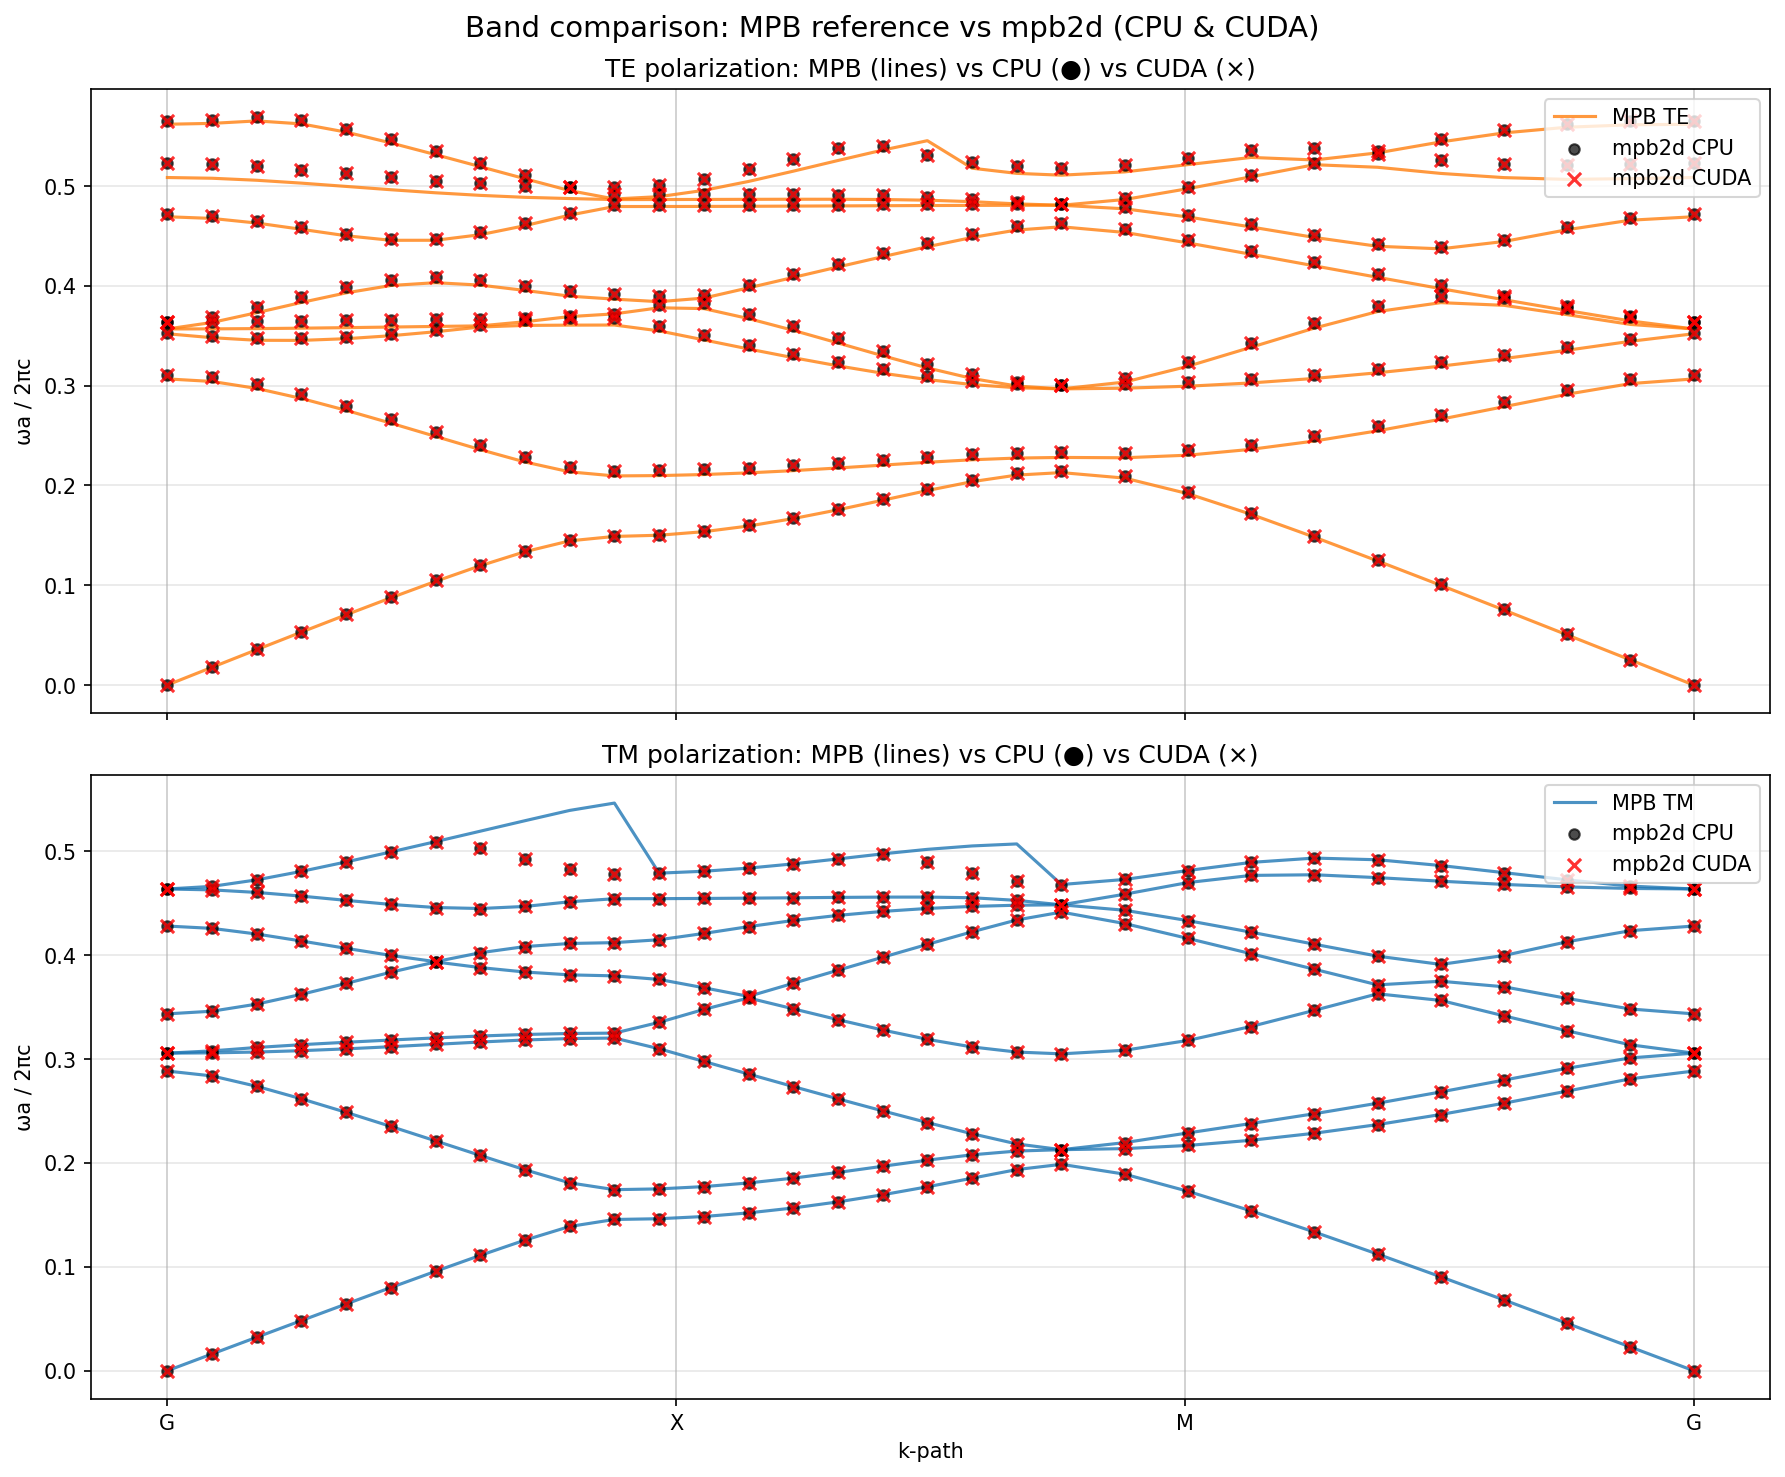

In [153]:
# ============================================================================
# CUDA Band Comparison: MPB (lines) vs mpb2d-CPU (dots) vs mpb2d-CUDA (x)
# ============================================================================
# Same as Cell 4, but with CUDA results overlaid

if cuda_data:
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, dpi=150)
    
    for row_idx, pol in enumerate(["TE", "TM"]):
        ax = axes[row_idx]
        
        # Plot MPB reference as lines
        mpb_data = load_dataset("mpb", pol)
        mpb_distances = align_distances(mpb_data.distances)
        for band_idx, band in enumerate(mpb_data.bands):
            label = f"MPB {pol}" if band_idx == 0 else None
            ax.plot(
                mpb_distances,
                band,
                color=POL_COLORS[pol],
                linewidth=1.5,
                label=label,
                alpha=0.8,
            )
        
        # Plot mpb2d-CPU with circles
        mpb2d_data = load_dataset("mpb2d", pol)
        mpb2d_distances = align_distances(mpb2d_data.distances)
        for band_idx, band in enumerate(mpb2d_data.bands):
            label = f"mpb2d CPU" if band_idx == 0 else None
            ax.scatter(
                mpb2d_distances,
                band,
                color="black",
                s=25,
                marker="o",
                label=label,
                zorder=3,
                alpha=0.7,
            )
        
        # Plot mpb2d-CUDA with X markers
        if pol in cuda_data:
            cuda_pol_data = cuda_data[pol]
            cuda_distances = align_distances(cuda_pol_data.distances)
            for band_idx, band in enumerate(cuda_pol_data.bands):
                label = f"mpb2d CUDA" if band_idx == 0 else None
                ax.scatter(
                    cuda_distances,
                    band,
                    color="red",
                    s=40,
                    marker="x",
                    label=label,
                    zorder=4,
                    alpha=0.8,
                    linewidths=1.5,
                )
        
        # Add high-symmetry point markers
        if node_positions:
            ax.set_xticks(node_positions)
            ax.set_xticklabels(node_labels)
            for pos in node_positions:
                ax.axvline(pos, color="0.85", linewidth=0.8, zorder=0)
        
        ax.set_ylabel("ωa / 2πc")
        ax.set_title(f"{pol} polarization: MPB (lines) vs CPU (●) vs CUDA (×)")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel("k-path")
    fig.suptitle("Band comparison: MPB reference vs mpb2d (CPU & CUDA)", fontsize=14)
    fig.tight_layout()
    plt.show()
else:
    print("CUDA data not available - skipping band comparison plot")

CPU vs CUDA EIGENVALUE VALIDATION

TE polarization:
  Max |ω_CUDA - ω_CPU|: 3.59e-14
  Mean |ω_CUDA - ω_CPU|: 1.68e-15
  RMS difference: 3.97e-15

TM polarization:
  Max |ω_CUDA - ω_CPU|: 5.27e-15
  Mean |ω_CUDA - ω_CPU|: 5.24e-16
  RMS difference: 8.42e-16


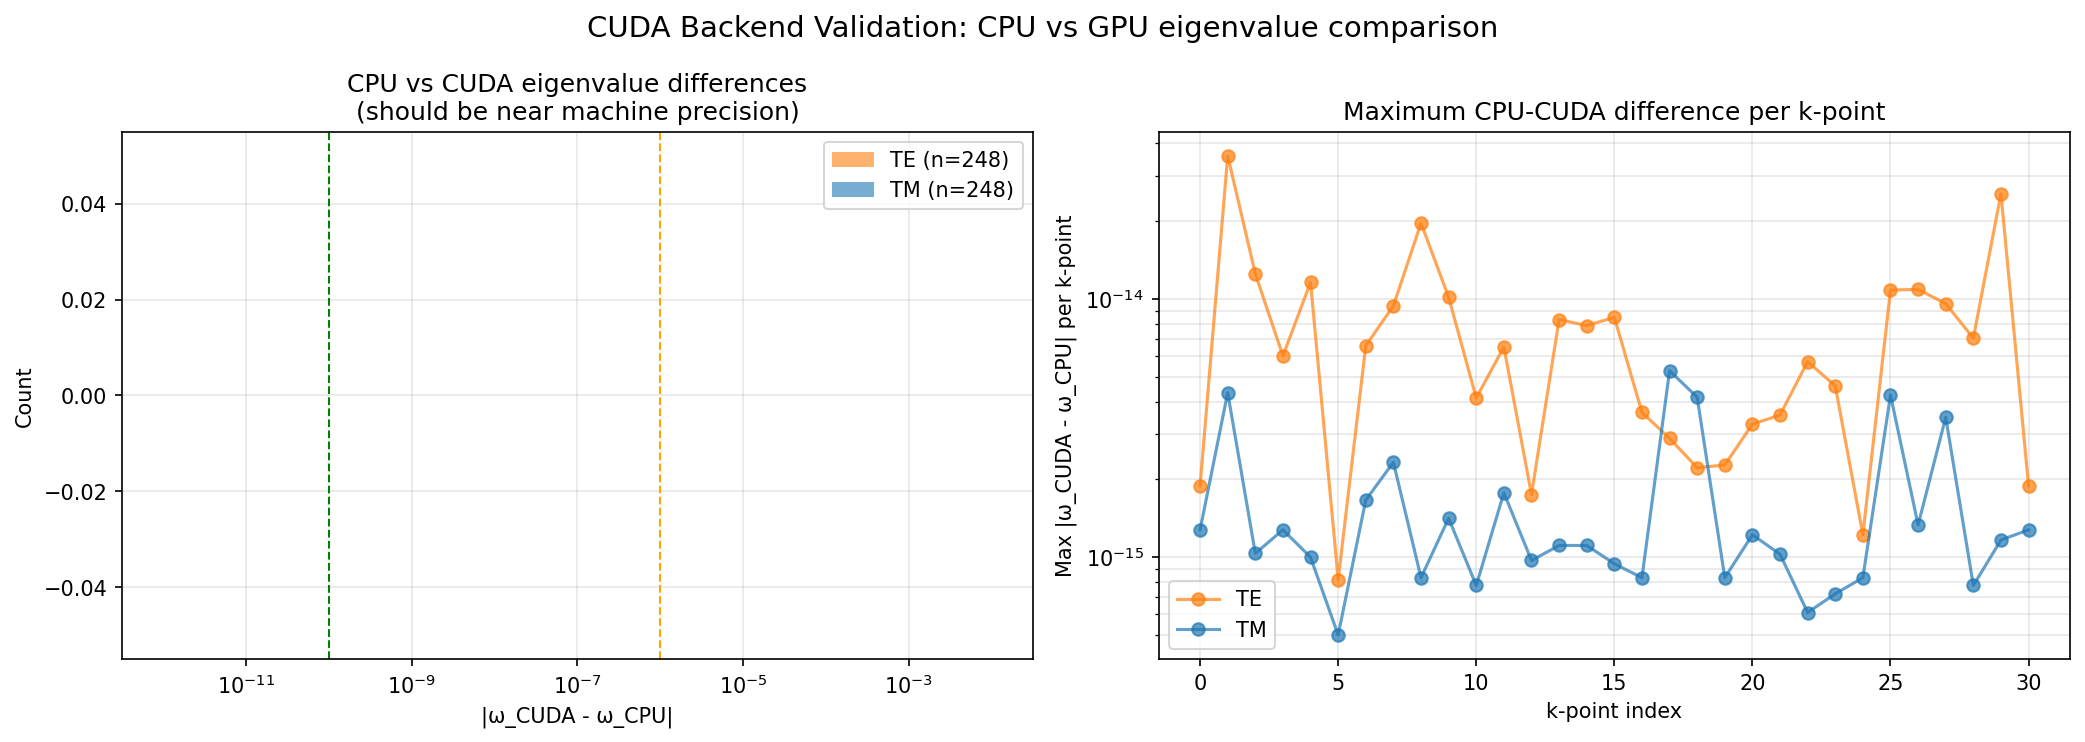

In [154]:
# ============================================================================
# CUDA Validation: CPU vs CUDA deviation analysis
# ============================================================================
# Compare mpb2d-CPU and mpb2d-CUDA eigenvalues to verify GPU correctness

if cuda_data:
    cuda_validation_results = {}
    
    for pol in ["TE", "TM"]:
        if pol not in cuda_data:
            continue
            
        cpu_data = load_dataset("mpb2d", pol)
        gpu_data = cuda_data[pol]
        
        cpu_bands = np.array(cpu_data.bands)
        gpu_bands = np.array(gpu_data.bands)
        
        # Direct comparison (same band ordering expected)
        diff = gpu_bands - cpu_bands
        
        cuda_validation_results[pol] = {
            'diff': diff,
            'max_abs_diff': np.nanmax(np.abs(diff)),
            'mean_abs_diff': np.nanmean(np.abs(diff)),
            'rms_diff': np.sqrt(np.nanmean(diff**2)),
        }
    
    # Print summary
    print("=" * 70)
    print("CPU vs CUDA EIGENVALUE VALIDATION")
    print("=" * 70)
    
    for pol in ["TE", "TM"]:
        if pol not in cuda_validation_results:
            continue
        res = cuda_validation_results[pol]
        print(f"\n{pol} polarization:")
        print(f"  Max |ω_CUDA - ω_CPU|: {res['max_abs_diff']:.2e}")
        print(f"  Mean |ω_CUDA - ω_CPU|: {res['mean_abs_diff']:.2e}")
        print(f"  RMS difference: {res['rms_diff']:.2e}")
    
    # Visualization: histogram and trace difference
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
    
    # --- Left plot: Histogram of differences ---
    ax_hist = axes[0]
    for pol in ["TE", "TM"]:
        if pol not in cuda_validation_results:
            continue
        diff_flat = cuda_validation_results[pol]['diff'].flatten()
        diff_flat = diff_flat[~np.isnan(diff_flat)]
        
        # Use log-spaced bins for absolute differences
        abs_diff = np.abs(diff_flat)
        bins = np.logspace(-12, -2, 50)
        ax_hist.hist(
            abs_diff,
            bins=bins,
            alpha=0.6,
            label=f"{pol} (n={len(diff_flat)})",
            color=POL_COLORS[pol],
        )
    
    ax_hist.set_xscale('log')
    ax_hist.set_xlabel("|ω_CUDA - ω_CPU|")
    ax_hist.set_ylabel("Count")
    ax_hist.set_title("CPU vs CUDA eigenvalue differences\n(should be near machine precision)")
    ax_hist.legend()
    ax_hist.grid(True, alpha=0.3, which='both')
    ax_hist.axvline(1e-10, color='green', linestyle='--', linewidth=1, label='1e-10')
    ax_hist.axvline(1e-6, color='orange', linestyle='--', linewidth=1, label='1e-6')
    
    # --- Right plot: Per-k-point max difference ---
    ax_kpt = axes[1]
    for pol in ["TE", "TM"]:
        if pol not in cuda_validation_results:
            continue
        diff = cuda_validation_results[pol]['diff']
        max_diff_per_k = np.nanmax(np.abs(diff), axis=0)
        ax_kpt.semilogy(max_diff_per_k, 'o-', label=pol, color=POL_COLORS[pol], alpha=0.7)
    
    ax_kpt.set_xlabel("k-point index")
    ax_kpt.set_ylabel("Max |ω_CUDA - ω_CPU| per k-point")
    ax_kpt.set_title("Maximum CPU-CUDA difference per k-point")
    ax_kpt.legend()
    ax_kpt.grid(True, alpha=0.3, which='both')
    
    fig.suptitle("CUDA Backend Validation: CPU vs GPU eigenvalue comparison", fontsize=14)
    fig.tight_layout()
    plt.show()
else:
    print("CUDA data not available - skipping validation plots")

In [155]:
# ============================================================================
# Data loaders for epsilon and iteration traces
# ============================================================================

EPSILON_CSV = REFERENCE_DIR / "compare_square_lowres_epsilon.csv"
EPSILON_MPB_CSV = REFERENCE_DIR / "compare_square_lowres_epsilon_mpb.csv"

# Inverse epsilon tensor CSVs
EPSILON_INV_TENSOR_CSV = REFERENCE_DIR / "compare_square_lowres_epsilon_tensor.csv"
EPSILON_INV_MPB_CSV = REFERENCE_DIR / "compare_square_lowres_epsilon_inv_mpb.csv"

# Iteration CSVs - same polarization convention as MPB
ITERATION_CSV_TE = REFERENCE_DIR / "compare_square_lowres_te_iterations.csv"
ITERATION_CSV_TM = REFERENCE_DIR / "compare_square_lowres_tm_iterations.csv"


def load_epsilon_data(path: Path) -> pd.DataFrame:
    """Load epsilon CSV with raw and smoothed values."""
    if not path.exists():
        raise FileNotFoundError(f"Epsilon CSV not found: {path}\nRun: make export-epsilon CONFIG=config/compare_square_lowres.mk")
    return pd.read_csv(path)


def load_mpb_epsilon_data(path: Path) -> pd.DataFrame:
    """Load MPB epsilon CSV."""
    if not path.exists():
        raise FileNotFoundError(f"MPB Epsilon CSV not found: {path}\nRun: make export-epsilon-mpb CONFIG=config/compare_square_lowres.mk")
    return pd.read_csv(path)


def load_epsilon_inv_tensor_data(path: Path) -> pd.DataFrame:
    """Load inverse epsilon tensor CSV (mpb2d format)."""
    if not path.exists():
        raise FileNotFoundError(f"Inverse epsilon tensor CSV not found: {path}\nRun: make export-epsilon-tensor CONFIG=config/compare_square_lowres.mk")
    return pd.read_csv(path)


def load_mpb_epsilon_inv_data(path: Path) -> pd.DataFrame:
    """Load MPB inverse epsilon tensor CSV."""
    if not path.exists():
        raise FileNotFoundError(f"MPB inverse epsilon tensor CSV not found: {path}\nRun: make export-epsilon-inverse-mpb CONFIG=config/compare_square_lowres.mk")
    return pd.read_csv(path)


def reshape_epsilon_grid(df: pd.DataFrame, column: str) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Reshape epsilon data into a 2D grid for plotting."""
    ordered = df.sort_values(["iy", "ix"])
    nx = int(ordered["ix"].max()) + 1
    ny = int(ordered["iy"].max()) + 1
    grid = ordered[column].to_numpy().reshape(ny, nx)
    
    # Get fractional coordinates
    xs = ordered[ordered["iy"] == 0]["frac_x"].to_numpy()
    ys = ordered[ordered["ix"] == 0]["frac_y"].to_numpy()
    return xs, ys, grid


def load_iteration_data(path: Path) -> pd.DataFrame | None:
    """Load iteration CSV with per-band convergence data."""
    if not path.exists():
        print(f"Iteration CSV not found: {path}")
        print("Run: make export-iterations CONFIG=config/compare_square_lowres.mk")
        return None
    return pd.read_csv(path)


def parse_iteration_bands(df: pd.DataFrame) -> dict:
    """Parse iteration data into per-band arrays."""
    # Find band columns
    band_cols = [c for c in df.columns if c.endswith("_residual")]
    num_bands = len(band_cols)
    
    result = {
        "iterations": df["iteration"].to_numpy(),
        "eigenvalues": [],
        "frequencies": [],
        "residuals": [],
    }
    
    for b in range(1, num_bands + 1):
        result["eigenvalues"].append(df[f"band{b}_eigenvalue"].to_numpy())
        result["frequencies"].append(df[f"band{b}_frequency"].to_numpy())
        result["residuals"].append(df[f"band{b}_residual"].to_numpy())
    
    return result

/tmp/ipykernel_14634/936042658.py:79: RuntimeWarning: Mean of empty slice
  avg_rel_change = np.nanmean(all_rel_changes, axis=0)


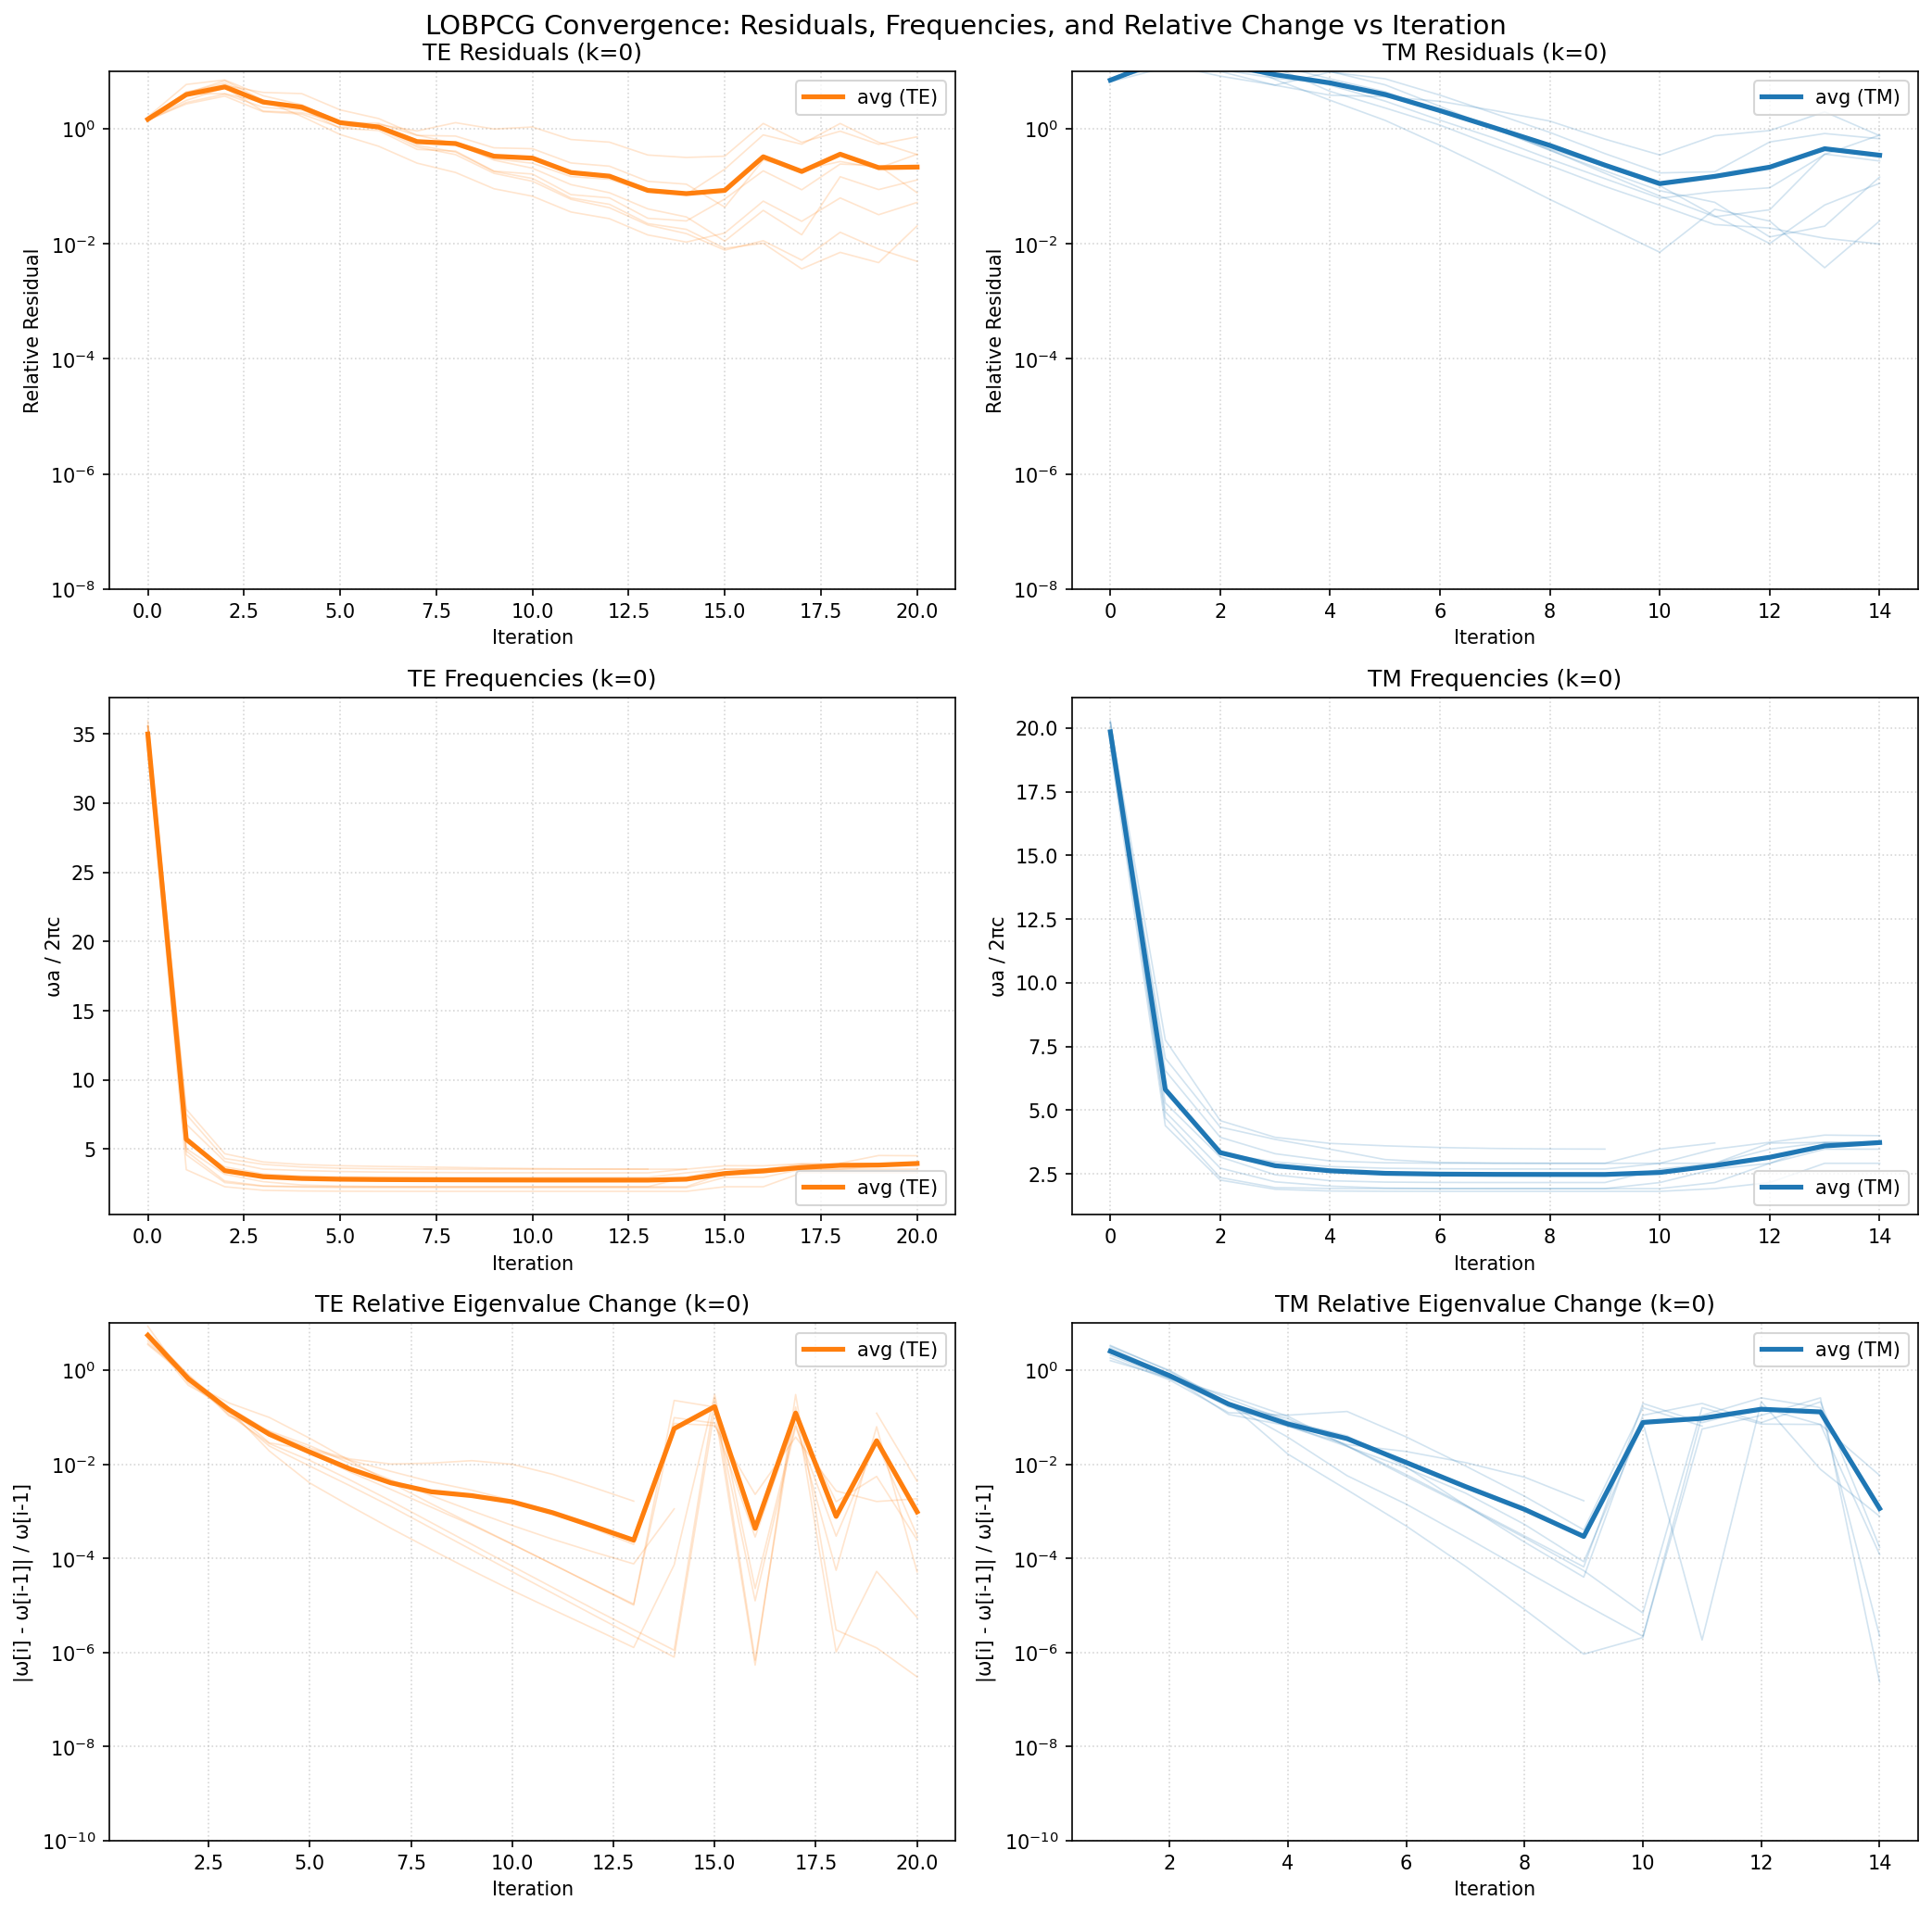

In [156]:
# ============================================================================
# Convergence plots: Residuals, Eigenvalues, and Relative Change vs Iteration
# ============================================================================
# Plot convergence data for TE and TM side by side

iteration_data = {}
for pol, path in [("TE", ITERATION_CSV_TE), ("TM", ITERATION_CSV_TM)]:
    df = load_iteration_data(path)
    if df is not None:
        # Filter to k_index=0 for a single representative k-point
        df_k0 = df[df["k_index"] == 0].copy()
        if len(df_k0) > 0:
            iteration_data[pol] = parse_iteration_bands(df_k0)

if not iteration_data:
    print("No iteration data available. Generate it with:")
    print("  cd python/evaluation && make export-iterations CONFIG=config/compare_square_lowres.mk")
else:
    # Create 3x2 grid: rows = [Residuals, Eigenvalues, Relative Change], cols = [TE, TM]
    fig, axes = plt.subplots(3, 2, figsize=(14, 14), dpi=150)
    
    for col_idx, pol in enumerate(["TE", "TM"]):
        if pol not in iteration_data:
            for row_idx in range(3):
                axes[row_idx, col_idx].text(0.5, 0.5, f"No {pol} data", 
                    ha="center", va="center", transform=axes[row_idx, col_idx].transAxes)
            continue
        
        data = iteration_data[pol]
        iters = data["iterations"]
        num_bands = len(data["residuals"])
        
        # --- Residuals (top row) ---
        ax_res = axes[0, col_idx]
        for b in range(num_bands):
            ax_res.semilogy(iters, data["residuals"][b], 
                           color=POL_COLORS[pol], alpha=0.2, linewidth=0.8)
        # Average residual
        avg_residual = np.nanmean(data["residuals"], axis=0)
        ax_res.semilogy(iters, avg_residual, color=POL_COLORS[pol], 
                       linewidth=2.5, label=f"avg ({pol})")
        ax_res.set_title(f"{pol} Residuals (k=0)")
        ax_res.set_xlabel("Iteration")
        ax_res.set_ylabel("Relative Residual")
        ax_res.grid(True, which="both", linestyle=":", alpha=0.5)
        ax_res.legend(loc="upper right")
        ax_res.set_ylim(1e-8, 10)
        
        # --- Eigenvalues (middle row) ---
        ax_eig = axes[1, col_idx]
        for b in range(num_bands):
            ax_eig.plot(iters, data["frequencies"][b], 
                       color=POL_COLORS[pol], alpha=0.2, linewidth=0.8)
        # Average frequency
        avg_freq = np.nanmean(data["frequencies"], axis=0)
        ax_eig.plot(iters, avg_freq, color=POL_COLORS[pol], 
                   linewidth=2.5, label=f"avg ({pol})")
        ax_eig.set_title(f"{pol} Frequencies (k=0)")
        ax_eig.set_xlabel("Iteration")
        ax_eig.set_ylabel("ωa / 2πc")
        ax_eig.grid(True, linestyle=":", alpha=0.5)
        ax_eig.legend(loc="lower right")
        
        # --- Relative eigenvalue change (bottom row) ---
        ax_rel = axes[2, col_idx]
        all_rel_changes = []
        for b in range(num_bands):
            freqs = np.array(data["frequencies"][b])
            # Compute relative change: |f[i] - f[i-1]| / f[i], skip where f[i-1] is 0
            rel_change = np.full_like(freqs, np.nan)
            for i in range(1, len(freqs)):
                if freqs[i] != 0:
                    rel_change[i] = np.abs(freqs[i] - freqs[i-1]) / np.abs(freqs[i])
            all_rel_changes.append(rel_change)
            ax_rel.semilogy(iters, rel_change, 
                           color=POL_COLORS[pol], alpha=0.2, linewidth=0.8)
        
        # Average relative change
        avg_rel_change = np.nanmean(all_rel_changes, axis=0)
        ax_rel.semilogy(iters, avg_rel_change, color=POL_COLORS[pol], 
                       linewidth=2.5, label=f"avg ({pol})")
        ax_rel.set_title(f"{pol} Relative Eigenvalue Change (k=0)")
        ax_rel.set_xlabel("Iteration")
        ax_rel.set_ylabel("|ω[i] - ω[i-1]| / ω[i-1]")
        ax_rel.grid(True, which="both", linestyle=":", alpha=0.5)
        ax_rel.legend(loc="upper right")
        ax_rel.set_ylim(1e-10, 10)
    
    fig.suptitle("LOBPCG Convergence: Residuals, Frequencies, and Relative Change vs Iteration", fontsize=14)
    fig.tight_layout()
    plt.show()


Grid size: 24 x 24
MPB ε: min=1.000, max=13.000
mpb2d ε: min=1.000, max=13.000


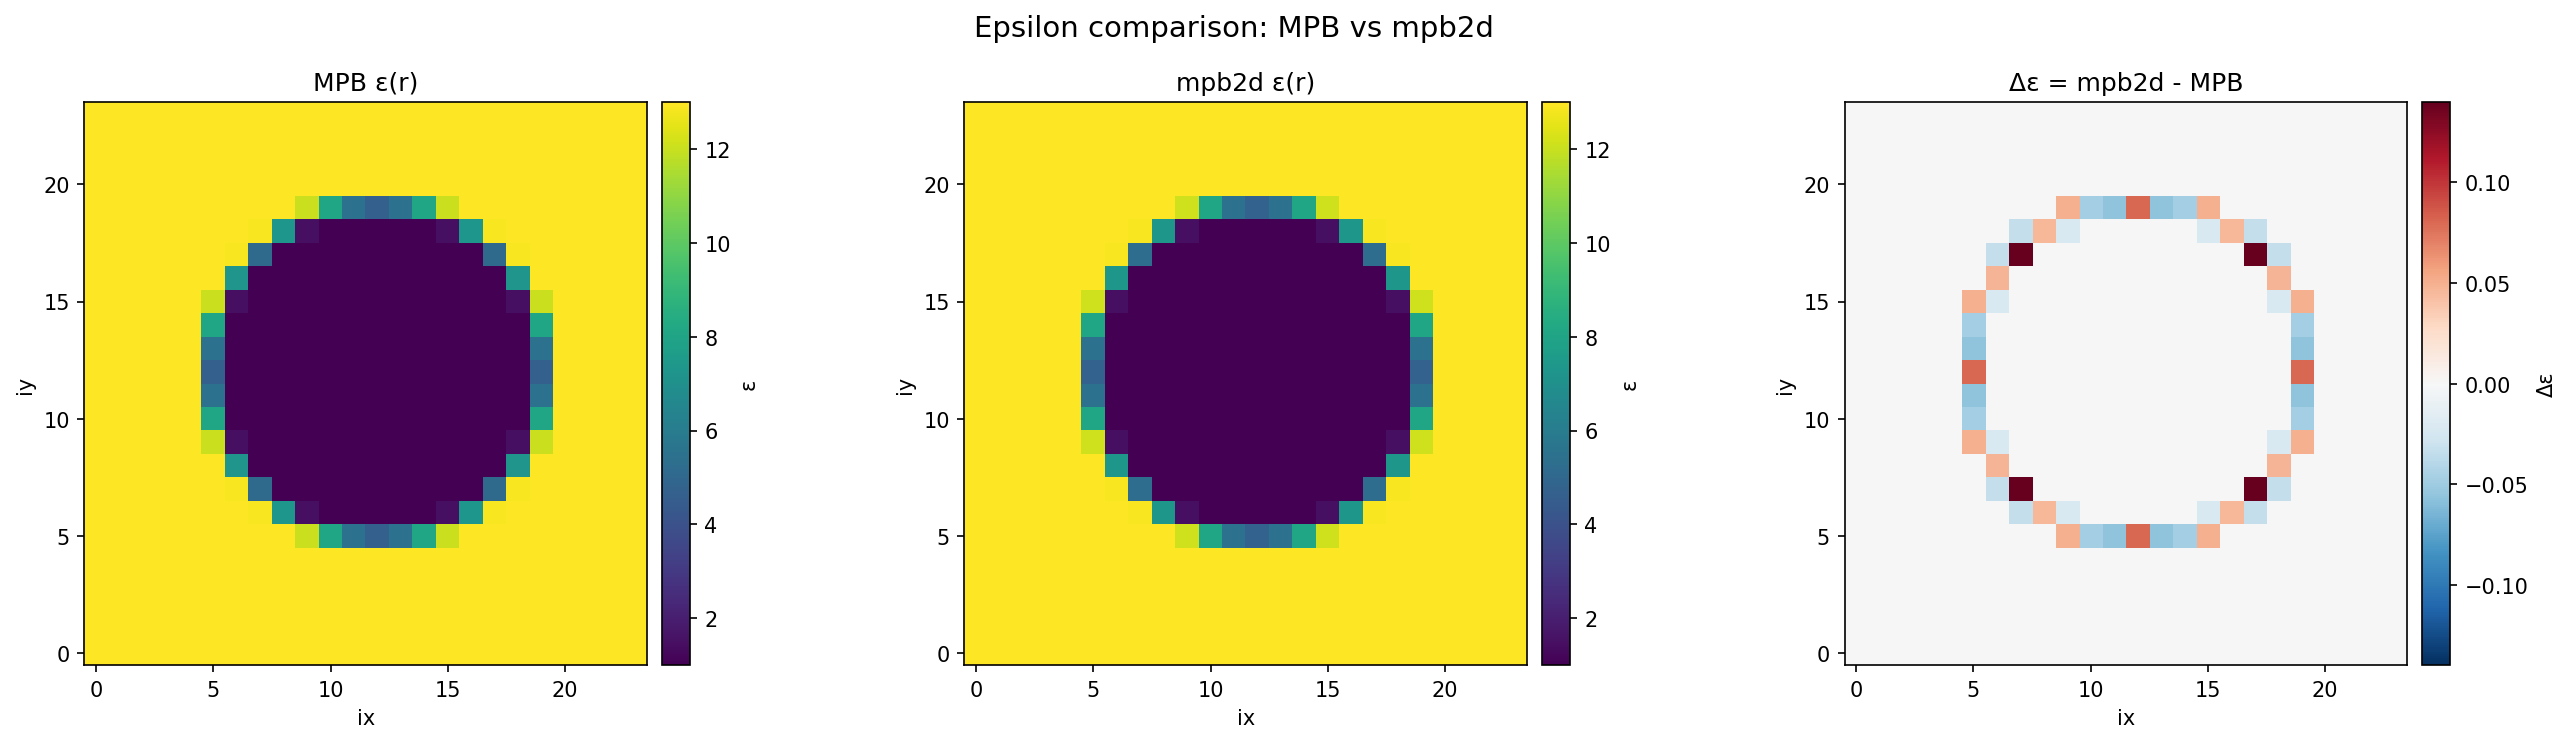


Max |Δε|: 0.1397, RMS: 0.0185, Relative error: 0.19%


In [157]:
# ============================================================================
# Epsilon plots: mpb2d vs MPB comparison
# ============================================================================
# Using imshow with integer indices for pure pixel-based display.

try:
    eps_df = load_epsilon_data(EPSILON_CSV)
    eps_mpb_df = load_mpb_epsilon_data(EPSILON_MPB_CSV)
    
    # Sort by (iy, ix) and reshape to 2D grids
    eps_df_sorted = eps_df.sort_values(["iy", "ix"])
    eps_mpb_df_sorted = eps_mpb_df.sort_values(["iy", "ix"])
    
    nx = int(eps_df_sorted["ix"].max()) + 1
    ny = int(eps_df_sorted["iy"].max()) + 1
    
    eps_mpb_grid = eps_mpb_df_sorted["eps_mpb"].to_numpy().reshape(ny, nx)
    eps_mpb2d_grid = eps_df_sorted["eps_smoothed"].to_numpy().reshape(ny, nx)
    eps_diff_grid = eps_mpb2d_grid - eps_mpb_grid
    
    print(f"Grid size: {nx} x {ny}")
    print(f"MPB ε: min={eps_mpb_grid.min():.3f}, max={eps_mpb_grid.max():.3f}")
    print(f"mpb2d ε: min={eps_mpb2d_grid.min():.3f}, max={eps_mpb2d_grid.max():.3f}")
    
    # 3-panel comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
    
    vmin = min(eps_mpb_grid.min(), eps_mpb2d_grid.min())
    vmax = max(eps_mpb_grid.max(), eps_mpb2d_grid.max())
    
    im0 = axes[0].imshow(eps_mpb_grid, origin="lower", cmap="viridis",
                          vmin=vmin, vmax=vmax, interpolation="nearest")
    axes[0].set_title("MPB ε(r)")
    axes[0].set_xlabel("ix")
    axes[0].set_ylabel("iy")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.02, label="ε")
    
    im1 = axes[1].imshow(eps_mpb2d_grid, origin="lower", cmap="viridis",
                          vmin=vmin, vmax=vmax, interpolation="nearest")
    axes[1].set_title("mpb2d ε(r)")
    axes[1].set_xlabel("ix")
    axes[1].set_ylabel("iy")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.02, label="ε")
    
    diff_max = np.abs(eps_diff_grid).max()
    im2 = axes[2].imshow(eps_diff_grid, origin="lower", cmap="RdBu_r",
                          vmin=-diff_max, vmax=diff_max, interpolation="nearest")
    axes[2].set_title(f"Δε = mpb2d - MPB")
    axes[2].set_xlabel("ix")
    axes[2].set_ylabel("iy")
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.02, label="Δε")
    
    fig.suptitle("Epsilon comparison: MPB vs mpb2d", fontsize=14)
    fig.tight_layout()
    plt.show()
    
    # Statistics
    rms_err = np.sqrt(np.mean(eps_diff_grid**2))
    rel_err = rms_err / np.mean(eps_mpb_grid) * 100
    print(f"\nMax |Δε|: {diff_max:.4f}, RMS: {rms_err:.4f}, Relative error: {rel_err:.2f}%")
    
except FileNotFoundError as e:
    print(e)

INVERSE EPSILON TENSOR COMPARISON (same convention after fix)
Grid: 24×24

Diagonal components (xx, yy):
  Δxx: Max|Δ|=0.008264, RMS=0.001259
  Δyy: Max|Δ|=0.008076, RMS=0.001253

Off-diagonal (xy):
  Δxy: Max|Δ|=0.003297, RMS=0.000524

Interface pixels: MPB=52, mpb2d=52


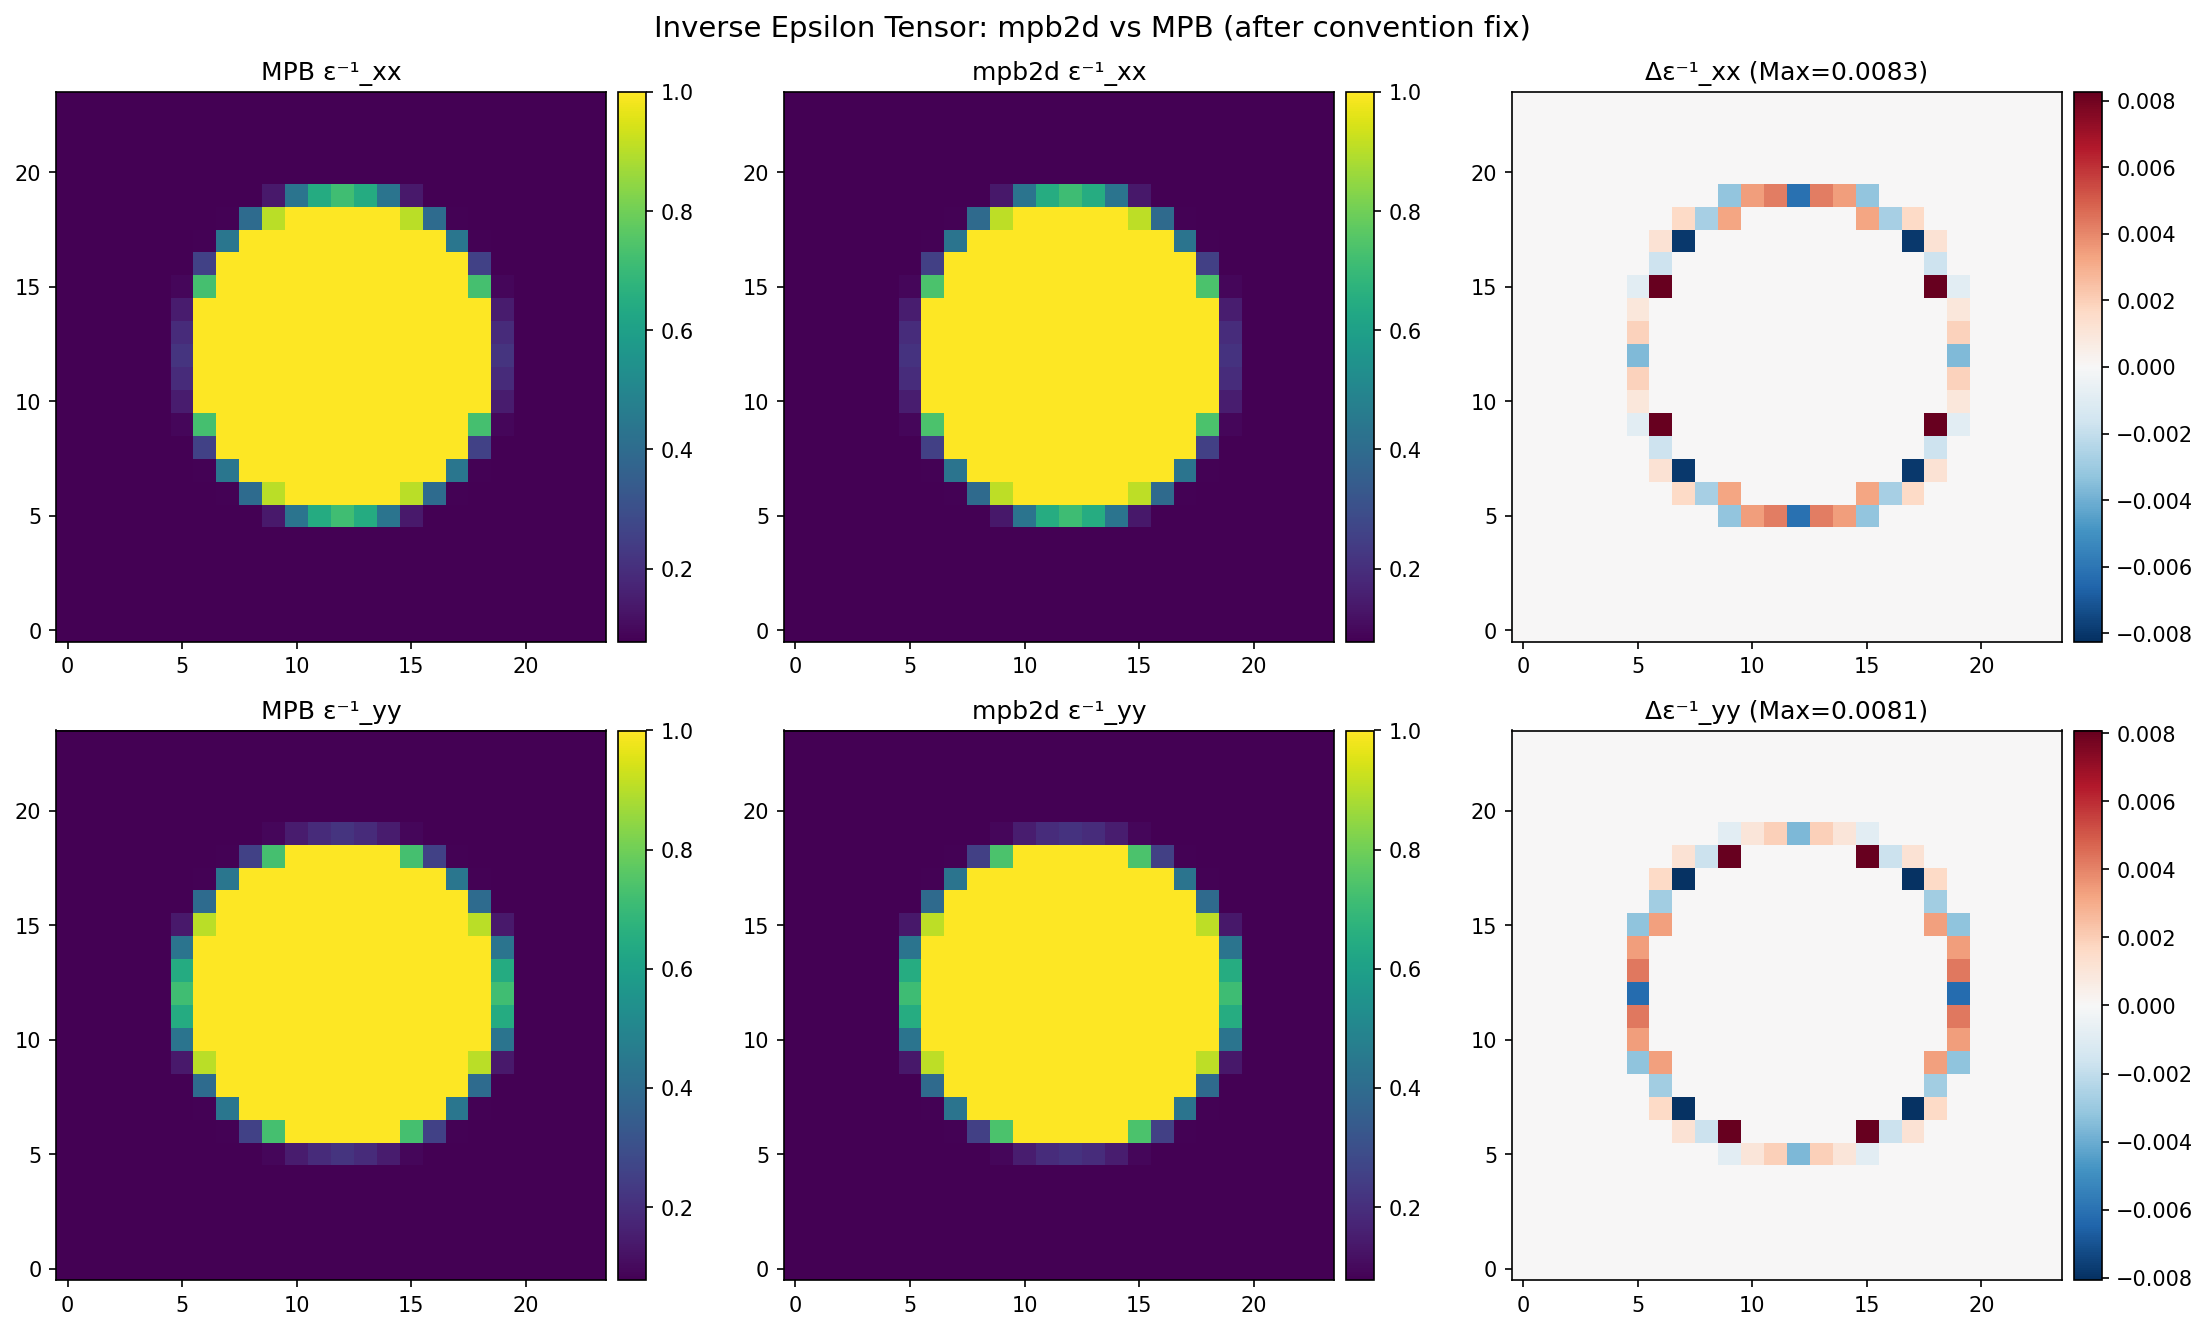

In [158]:
# ============================================================================
# Inverse Epsilon Tensor Comparison: mpb2d vs MPB RAW HDF5
# ============================================================================
# Compares the ε⁻¹ tensor grids used by the TE operator: -∇·(ε⁻¹∇)H_z
# Uses MPB's RAW HDF5 grid data (no interpolation) for true comparison.
# After fix: both mpb2d and MPB now use the same xx↔yy convention.

EPSILON_INV_H5_CSV = REFERENCE_DIR / "compare_square_lowres_epsilon_inv_h5.csv"

def load_mpb_epsilon_inv_h5_data(path: Path) -> pd.DataFrame:
    """Load MPB's RAW inverse epsilon tensor from HDF5 export."""
    if not path.exists():
        raise FileNotFoundError(f"MPB HDF5 inverse epsilon not found: {path}\n"
                               "Run: make export-epsilon-inverse-h5 CONFIG=config/compare_square_lowres.mk")
    return pd.read_csv(path)

try:
    inv_eps_mpb2d_df = load_epsilon_inv_tensor_data(EPSILON_INV_TENSOR_CSV).sort_values(["iy", "ix"])
    inv_eps_h5_df = load_mpb_epsilon_inv_h5_data(EPSILON_INV_H5_CSV).sort_values(["iy", "ix"])
    
    nx = int(inv_eps_mpb2d_df["ix"].max()) + 1
    ny = int(inv_eps_mpb2d_df["iy"].max()) + 1
    
    # Extract grids - after fix, both use same convention (direct comparison)
    mpb_xx = inv_eps_h5_df["inv_eps_xx"].to_numpy().reshape(ny, nx)
    mpb_yy = inv_eps_h5_df["inv_eps_yy"].to_numpy().reshape(ny, nx)
    mpb_xy = inv_eps_h5_df["inv_eps_xy"].to_numpy().reshape(ny, nx)
    mpb2d_xx = inv_eps_mpb2d_df["inv_eps_xx"].to_numpy().reshape(ny, nx)
    mpb2d_yy = inv_eps_mpb2d_df["inv_eps_yy"].to_numpy().reshape(ny, nx)
    mpb2d_xy = inv_eps_mpb2d_df["inv_eps_xy"].to_numpy().reshape(ny, nx)
    
    # Compute differences
    diff_xx = mpb2d_xx - mpb_xx
    diff_yy = mpb2d_yy - mpb_yy
    diff_xy = mpb2d_xy - mpb_xy
    
    # Statistics
    print("="*70)
    print("INVERSE EPSILON TENSOR COMPARISON (same convention after fix)")
    print("="*70)
    print(f"Grid: {nx}×{ny}")
    print(f"\nDiagonal components (xx, yy):")
    print(f"  Δxx: Max|Δ|={np.abs(diff_xx).max():.6f}, RMS={np.sqrt(np.mean(diff_xx**2)):.6f}")
    print(f"  Δyy: Max|Δ|={np.abs(diff_yy).max():.6f}, RMS={np.sqrt(np.mean(diff_yy**2)):.6f}")
    print(f"\nOff-diagonal (xy):")
    print(f"  Δxy: Max|Δ|={np.abs(diff_xy).max():.6f}, RMS={np.sqrt(np.mean(diff_xy**2)):.6f}")
    print(f"\nInterface pixels: MPB={np.sum(np.abs(mpb_xy) > 1e-10)}, mpb2d={np.sum(np.abs(mpb2d_xy) > 1e-10)}")
    
    # Visualization: 2x3 grid (xx, yy rows; MPB, mpb2d, diff columns)
    fig, axes = plt.subplots(2, 3, figsize=(15, 9), dpi=150)
    
    for row, (mpb_comp, mpb2d_comp, diff_comp, name) in enumerate([
        (mpb_xx, mpb2d_xx, diff_xx, "xx"),
        (mpb_yy, mpb2d_yy, diff_yy, "yy"),
    ]):
        vmin, vmax = min(mpb_comp.min(), mpb2d_comp.min()), max(mpb_comp.max(), mpb2d_comp.max())
        
        im0 = axes[row, 0].imshow(mpb_comp, origin="lower", cmap="viridis", 
                                   vmin=vmin, vmax=vmax, interpolation="nearest")
        axes[row, 0].set_title(f"MPB ε⁻¹_{name}")
        fig.colorbar(im0, ax=axes[row, 0], fraction=0.046, pad=0.02)
        
        im1 = axes[row, 1].imshow(mpb2d_comp, origin="lower", cmap="viridis",
                                   vmin=vmin, vmax=vmax, interpolation="nearest")
        axes[row, 1].set_title(f"mpb2d ε⁻¹_{name}")
        fig.colorbar(im1, ax=axes[row, 1], fraction=0.046, pad=0.02)
        
        dmax = np.abs(diff_comp).max()
        im2 = axes[row, 2].imshow(diff_comp, origin="lower", cmap="RdBu_r",
                                   vmin=-dmax, vmax=dmax, interpolation="nearest")
        axes[row, 2].set_title(f"Δε⁻¹_{name} (Max={dmax:.4f})")
        fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.02)
    
    fig.suptitle("Inverse Epsilon Tensor: mpb2d vs MPB (after convention fix)", fontsize=14)
    fig.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(e)